# CIFAR-10 classification


In [55]:
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import transforms
import matplotlib.pyplot as plt
import numpy as np
from torchmetrics import Accuracy
import torch.optim as optim

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Using {device} device')

Using cpu device


In [23]:
## Define basic transformation and define the datasets

train_transform = transforms.Compose([
  transforms.ToTensor()
])


train_dataset = datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=train_transform,
)

test_dataset = datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
)

classes = train_dataset.classes

train_dataset, test_dataset, classes

(Dataset CIFAR10
     Number of datapoints: 50000
     Root location: ./data
     Split: Train
     StandardTransform
 Transform: Compose(
                ToTensor()
            ),
 Dataset CIFAR10
     Number of datapoints: 10000
     Root location: ./data
     Split: Test,
 ['airplane',
  'automobile',
  'bird',
  'cat',
  'deer',
  'dog',
  'frog',
  'horse',
  'ship',
  'truck'])

In [35]:
## Create the dataloaders

BATCH_SIZE = 32
NUM_WORKERS = 2

trainloader = DataLoader(train_dataset,
                         batch_size = BATCH_SIZE,
                         num_workers = NUM_WORKERS,
                         shuffle = True )


testloader = DataLoader(test_dataset,
                         batch_size = BATCH_SIZE,
                         num_workers = NUM_WORKERS,
                         shuffle = False )

trainloader, testloader

(<torch.utils.data.dataloader.DataLoader at 0x79b5a5a97c10>,
 <torch.utils.data.dataloader.DataLoader at 0x79b5a5a97490>)

torch.Size([3, 32, 32])


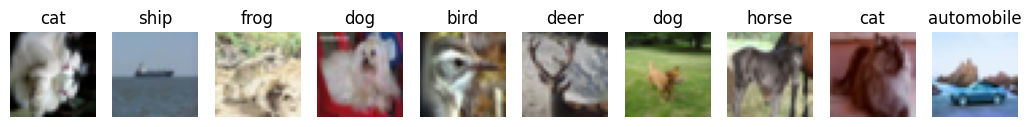

In [37]:
## Data visualization

def show_images(loader: DataLoader, num_images: int):
  images, labels = next(iter(loader))

  print(images[0].shape)

  fig, ax = plt.subplots(1, num_images, figsize=(13,2))

  for i in range(num_images):
    img = images[i]
    ax[i].imshow(np.transpose(img, (1,2,0)))
    ax[i].set_title(f'{classes[labels[i]]}') # Print the titles
    ax[i].axis('off') # Deactivate axes

show_images(trainloader, 10)


## Model definition

In [64]:
class baseline_model_cnn(nn.Module):
  def __init__(self, num_classes, num_filters: int = 64):
    super(baseline_model_cnn, self).__init__()
    self.features = nn.Sequential(
        nn.Conv2d(in_channels = 3,
                  out_channels = num_filters,
                  kernel_size = 3,
                  padding = 1,
                  ),
        nn.BatchNorm2d(num_filters),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),

        nn.Conv2d(in_channels = num_filters,
                  out_channels = num_filters*2,
                  kernel_size = 3,
                  padding = 1,
                  ),
        nn.BatchNorm2d(num_filters*2),
        nn.ReLU(inplace=True),
        nn.MaxPool2d(kernel_size=2, stride=2),
    )

    self.classifier = nn.Sequential(
        nn.AdaptiveAvgPool2d((7, 7)),
        nn.Flatten(),
        nn.Linear(num_filters*2 * 7 * 7, 512),
        nn.ReLU(inplace = True),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes)

    )

  def forward(self, x):
    x = self.features(x)
    return self.classifier(x)

model_0 = baseline_model_cnn(len(classes))
model_0

baseline_model_cnn(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (4): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (5): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU(inplace=True)
    (7): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): AdaptiveAvgPool2d(output_size=(7, 7))
    (1): Flatten(start_dim=1, end_dim=-1)
    (2): Linear(in_features=6272, out_features=512, bias=True)
    (3): ReLU(inplace=True)
    (4): Dropout(p=0.5, inplace=False)
    (5): Linear(in_features=512, out_features=10, bias=True)
  )
)

### Define loss function and optimizer

In [74]:
def train_model(model, train_loader, val_loader, num_epochs, loss_fn, optimizer, scheduler):

  model.to(device)

  train_accuracy = Accuracy(task = "multiclass", num_classes = len(classes)).to(device)
  val_accuracy = Accuracy(task = "multiclass", num_classes = len(classes)).to(device)

  history = {'train_loss': [], 'val_loss': [], 'train_acc': [], 'val_acc': []}

  for epoch in range(num_epochs):

    # 1. Set model into training mode
    model.train()
    train_loss = 0
    train_accuracy.reset()

    # Loop over batches
    for batch, (data, target) in enumerate(train_loader):
      data, target = data.to(device), target.to(device)

      # 2. Forward pass
      y_pred = model(data)

      # 3. Calculate loss
      loss = loss_fn(y_pred, target)

      # 4. Zero grad optimizer
      optimizer.zero_grad() # Set gradients to zero

      # 5. Loss backward
      loss.backward()

      # 6. Optimizer step
      optimizer.step()

      # Compute loss and accuracy
      train_loss += loss.item()
      train_accuracy.update(y_pred, target)

    ## Validation
    model.eval()
    val_loss = 0
    val_accuracy.reset()

    with torch.no_grad():
      for data, target in val_loader:
        data, target = data.to(device), target.to(device)

        # Compute prediction
        y_pred = model(data)

        # Compute loss
        loss = loss_fn(y_pred, target)

        # Update loss and accuracy
        val_loss += loss.item()
        val_accuracy.update(y_pred, target)


    scheduler.step()

    train_epoch_loss = train_loss / len(train_loader)
    val_epoch_loss = val_loss / len(val_loader)
    train_epoch_accuracy = train_accuracy / len(train_loader)
    val_epoch_accuracy = val_accuracy / len(val_loader)

    history['train_loss'].append(train_epoch_loss)
    history['train_acc'].append(train_epoch_accuracy)
    history['val_loss'].append(val_epoch_loss)
    history['val_acc'].append(val_epoch_accuracy)

    if epoch % 1 == 0:

      print(f"Epoch {epoch+1/(len(num_epochs)+1)}")
      print(f"Train loss: {train_epoch_loss:.4f} | Accuracy accuracy: {train_epoch_accuracy:.4f}")
      print(f"Validation loss: {val_epoch_loss:.4f} | Validation accuracy: {val_epoch_accuracy:.4f}")
      print('-' * 50)

  return history

Now we can train

In [75]:
# Create baseline model
model_0 = baseline_model_cnn(len(classes))


# Define loss function and optimizer
learning_rate = 0.1
weight_decay = 0.01

loss_fn = nn.CrossEntropyLoss(label_smoothing=0.1)
optimizer = optim.AdamW(model_0.parameters(), lr=learning_rate, weight_decay=weight_decay)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)

# Number epochs
NUM_EPOCHS = 3


train_model(model = model_0,
            train_loader = trainloader,
            val_loader = testloader,
            num_epochs = NUM_EPOCHS,
            loss_fn = loss_fn,
            optimizer = optimizer,
            scheduler = scheduler)


KeyboardInterrupt: 